# Minimal Working Example 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")


from stabnode.utils import set_global_seed
from data.budworm import simulate_trials, budworm_steady_states


seed = 1234
set_global_seed(seed=seed)
device = 'cpu'

## Generate multiple trajectories for $k=5.34$ (trial 0, one steady state case)

In [2]:
k = 5.34569072482332

In [3]:
xs = []
ts = []

x0s = np.linspace(0.1,10,51)
for x0 in x0s:
    budworm_trial =simulate_trials([k],x0, dt=0.1,r=0.56,eps=1e-3,buffer=1e-1,t_max=400,n_points=501, show_progress=False)
    xs.append(budworm_trial.x_vals[0])
    ts.append(budworm_trial.t_vals[0])

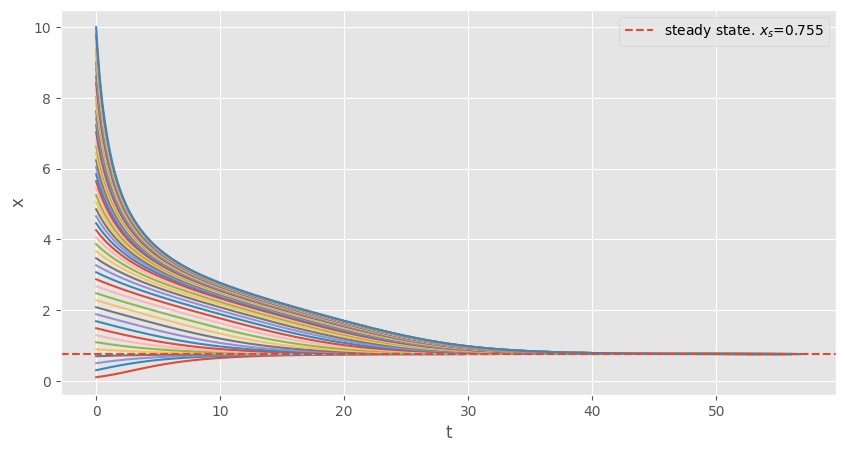

In [4]:
# expected steady states for fixed k and r
steady_states = budworm_steady_states(k,r=0.56)

plt.figure(figsize=(10,5))
for ti, xi in zip(ts, xs):
    plt.plot(ti,xi)
for x_steady_state in steady_states:
    plt.axhline(x_steady_state, linestyle='--',label=rf"steady state. $x_s$={x_steady_state:.3f}")
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()

## preprocess data and create data loader

In [5]:
import torch
from sklearn.preprocessing import MinMaxScaler
from stabnode.data import TrialsDataset

In [6]:
scaler = MinMaxScaler()
scaler.fit(np.concatenate(xs).reshape(-1,1))

xs_scaled = [scaler.transform(xi.reshape(-1,1)).reshape(-1) for xi in xs]

In [7]:
xs_torch = [torch.tensor(xi,dtype=torch.float32,device=device) for xi in xs_scaled]
ts_torch = [torch.tensor(ti,dtype=torch.float32,device=device) for ti in ts]

In [8]:
train_dataset = TrialsDataset(x_trials=xs_torch, t_trials=ts_torch)
train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=False,batch_size=1,num_workers=0)

# Create and train model

In [9]:
import torch.nn as nn
from stabnode.node import GeluSigmoid, FeluSigmoid, StabNODE, model_trainer

In [10]:
# create new classes for constant f and g

f = FeluSigmoid(
    dim_in=1,
    dim_out=1,
    hidden_dim=8,
    lower_bound=-0.5,
    upper_bound=-0.1
)

g = GeluSigmoid(
    dim_in=1+1, # input is x dim + k dim
    dim_out=1,
    hidden_dim=8,
    lower_bound=-5,
    upper_bound=1.1  
)

model = StabNODE(f,g).to(device)

In [ ]:
n_epochs = 200
lr = 1e-3
show_progress = True
solve_method = 'tsit5'
loss_criteria = nn.MSELoss()
opt = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,mode='min',factor=0.1,patience=10)

model, log_history = model_trainer(
    model=model,
    opt=opt,
    loss_criteria=loss_criteria,
    train_loader=train_loader,
    n_epochs=n_epochs,
    control=lambda t: torch.tensor(k,dtype=torch.float32,device=device).unsqueeze(0),
    min_improvement=1e-6,
    patience=30,
    solve_method='tsit5',
    save_folder=None,
    show_progress=True,
    scheduler=scheduler,
    print_every=10,
    _precision=7,
)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0: Loss: 0.0042647. time = 16.6156020s. lr = 0.0010000
Epoch 1: Loss: 0.0022305. time = 15.0812650s. lr = 0.0010000
Epoch 2: Loss: 0.0017983. time = 15.7111161s. lr = 0.0010000
Epoch 3: Loss: 0.0015425. time = 16.4663970s. lr = 0.0010000
Epoch 4: Loss: 0.0013258. time = 16.1227291s. lr = 0.0010000
Epoch 5: Loss: 0.0011811. time = 15.4175429s. lr = 0.0010000
Epoch 10: Loss: 0.0009696. time = 14.9363179s. lr = 0.0010000
Epoch 20: Loss: 0.0007096. time = 14.6077850s. lr = 0.0010000
Epoch 30: Loss: 0.0004725. time = 13.8956170s. lr = 0.0010000
Epoch 40: Loss: 0.0003490. time = 13.4211349s. lr = 0.0010000
Epoch 50: Loss: 0.0003027. time = 12.9402580s. lr = 0.0010000
Epoch 60: Loss: 0.0002544. time = 12.8023310s. lr = 0.0010000
Epoch 70: Loss: 0.0002124. time = 12.6890049s. lr = 0.0010000
Epoch 80: Loss: 0.0001894. time = 12.9136500s. lr = 0.0010000
Epoch 90: Loss: 0.0001747. time = 12.8840630s. lr = 0.0010000
Epoch 100: Loss: 0.0001650. time = 12.6510453s. lr = 0.0010000
Epoch 110: Lo

In [12]:
print(log_history["stopping_criteria"])

max-epochs


# Look at results

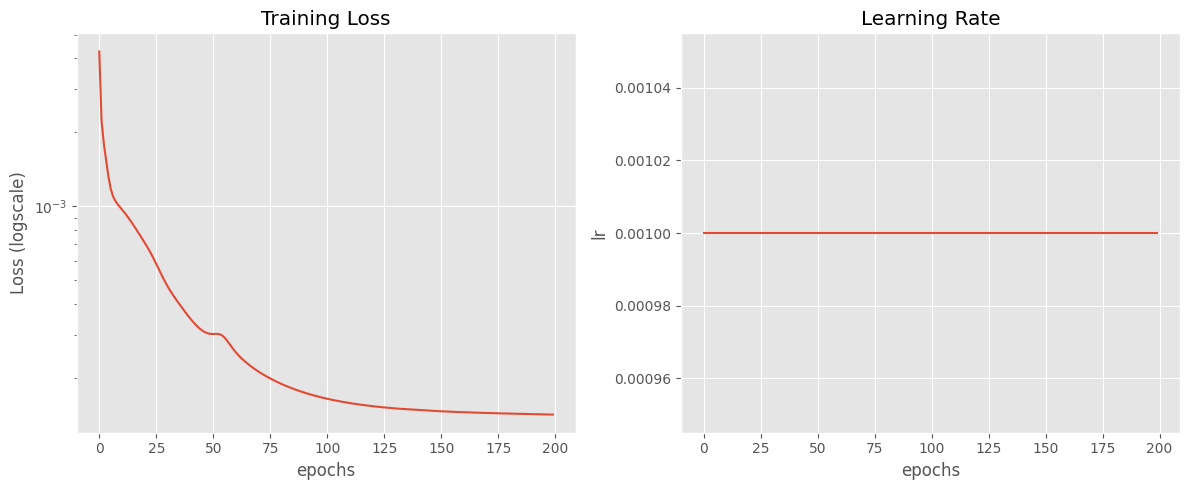

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.set_title("Training Loss")
ax1.plot(log_history["losses"])
ax1.set_yscale('log')
ax1.set_xlabel("epochs")
ax1.set_ylabel("Loss (logscale)")

ax2.set_title("Learning Rate")
ax2.plot(log_history['lr_hist'])
ax2.set_xlabel('epochs')
ax2.set_ylabel("lr")

plt.tight_layout()
plt.show()

## Learned trajectories via solving `stabnode` model with `torchode.solve_ivp`

In [14]:
from torchode import solve_ivp
from tqdm.auto import tqdm

In [15]:
g_eval = model.g.eval()
f_eval = model.f.eval()

model_eval = StabNODE(f_eval,g_eval)

In [16]:
scaled_steady_states = scaler.transform(np.array(budworm_steady_states(k,r=0.56)).reshape(-1,1)).reshape(-1)

  0%|          | 0/51 [00:00<?, ?it/s]

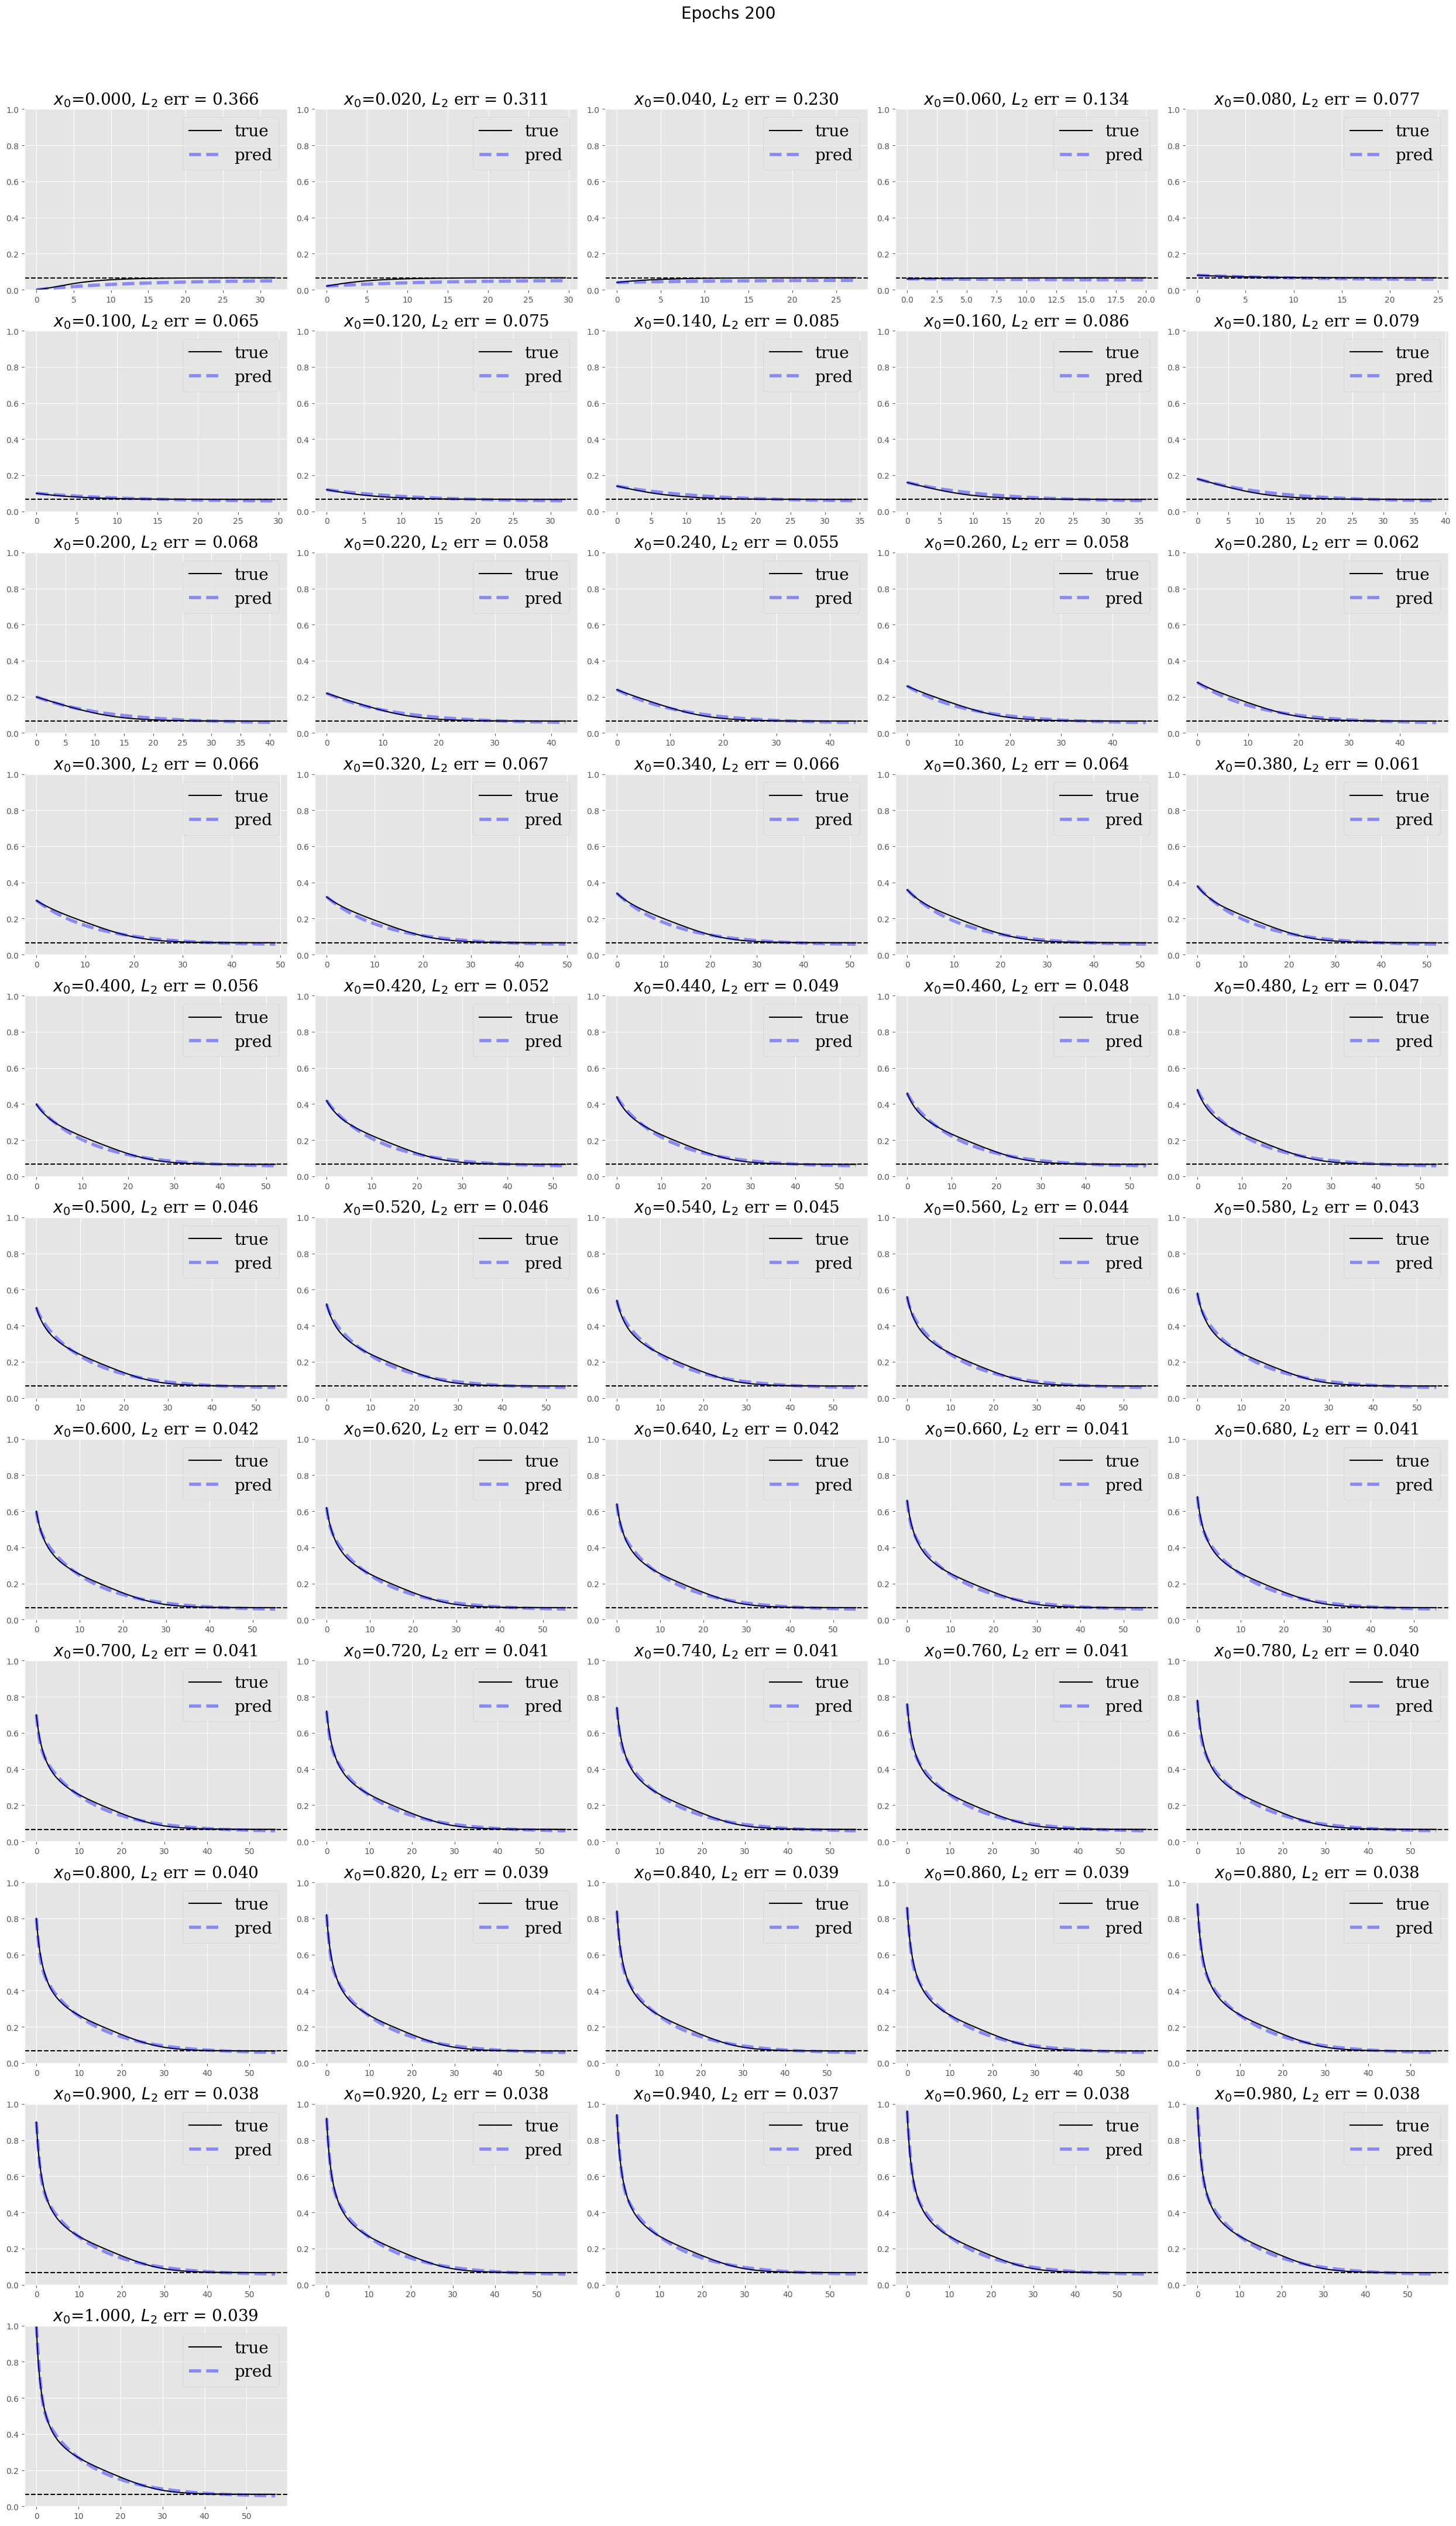

In [17]:
cols = 5
rows = int(np.ceil(len(train_dataset)/cols))

fig, axs = plt.subplots(rows, cols,figsize=(5*cols,4*rows))

axs = axs.flatten()

control_func = lambda t: torch.tensor(k,dtype=torch.float32,device=device).unsqueeze(0)
with torch.no_grad():
    for idx in tqdm(range(len(train_dataset))):
        ax = axs[idx]
        xi, ti, x0i = train_dataset[idx]

        sol = solve_ivp(
            f=lambda t, x: model_eval(t, x, control_func),
            y0=x0i.reshape(-1,1),
            t_eval=ti,
            method=solve_method
        )

        rel_l2_err = np.linalg.norm(sol.ys.squeeze() - xi)/np.linalg.norm(xi)

        ax.plot(ti,xi,label='true',color='black')
        ax.plot(sol.ts.squeeze(),sol.ys.squeeze(),label="pred", linestyle='--', color='blue',alpha=0.4,lw=4)
        ax.set_ylim(0,1)
        ax.set_title(rf"$x_0$={x0i:.3f}, $L_2$ err = {rel_l2_err:.3f}", family='serif',size=20)
        ax.legend(prop={'family':'serif','size':20})

        for idx,xsi in enumerate(scaled_steady_states):
            label = rf"steady state. $x_s=${xsi:.3f}"
            color = 'black'
            if idx ==1:
                label = rf"unsteady state. $x_s=${xsi:.3f}"
                color = 'red'

            ax.axhline(
                xsi,
                xmin=0,
                c=color,
                linestyle="--",
                label=label,
                zorder=2
            )

    for idx in range(len(train_dataset), rows*cols):
        fig.delaxes(axs[idx])

plt.suptitle(f"Epochs {n_epochs}", size=20)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()


# Learned vs True $g$ and $f$ 

In [18]:
from data.budworm import g_true, f_true

In [19]:
x_lin = np.linspace(0,1,101)
with torch.no_grad():
    x_lin_torch = torch.tensor(x_lin, dtype=torch.float32)
    f_pred = [f_eval(xi.reshape(-1,1)).reshape(-1) for xi in x_lin_torch]
    f_pred = torch.cat(f_pred)
    
    k_torch = torch.tensor(k,dtype=torch.float32).reshape(-1,1)
    g_pred =torch.cat([g_eval(torch.tensor([[xi]],dtype=torch.float32),k_torch).reshape(-1) for xi in x_lin_torch])

x_lin_unscaled = scaler.inverse_transform(x_lin.reshape(-1,1)).squeeze()

f_true_arr =  f_true(x_lin_unscaled)
g_true_arr = scaler.transform(g_true(x_lin_unscaled, k, r=0.56).reshape(-1,1)).squeeze()

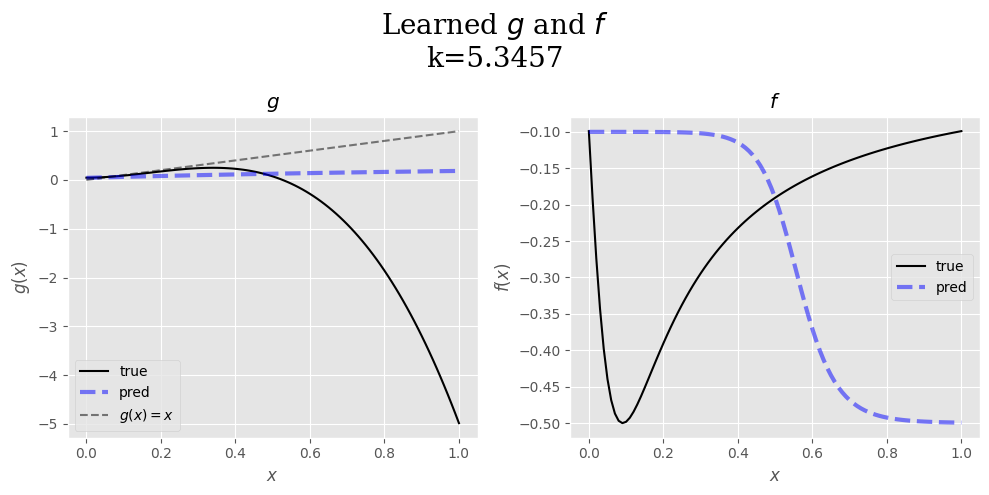

In [20]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.plot(x_lin, g_true_arr,label='true',c='black')
ax1.plot(x_lin_torch, g_pred, label='pred', linestyle='--', c='blue', alpha=0.5, lw=3)
ax1.plot(x_lin, x_lin, c='black', linestyle='--',alpha=0.5,label=r"$g(x)=x$")
ax1.set_title(r"$g$")
ax1.set_xlabel(r"$x$")
ax1.set_ylabel(r"$g(x)$")
# ax1.set_ylim(-0.1,1)
ax1.legend()

ax2.plot(x_lin, f_true_arr, label='true', c='black')
ax2.plot(x_lin_torch, f_pred, label='pred',linestyle='--',c='blue',lw=3,alpha=0.5)
ax2.set_xlabel(r"$x$")
ax2.set_ylabel(r"$f(x)$")
ax2.set_title(r"$f$")
ax2.legend()
plt.suptitle(r"Learned $g$ and $f$"+f"\nk={k:.4f}", family='serif', size=20)
plt.tight_layout()
plt.show()